In [1]:
# https://nextjournal.com/gkoehler/pytorch-mnist

import pandas as pd
from collections import Counter
import numpy as np
from tqdm import tqdm
import requests
from IPython.display import HTML
import operator
import pickle
import os
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torchvision
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

!cp "/content/gdrive/My Drive/PyTorch/utils/torch_wrapper.py" "/content"
from torch_wrapper import TorchWrapper
!cp "/content/gdrive/My Drive/PyTorch/utils/utils.py" "/content"
import utils
%load_ext autoreload
%autoreload 2

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


# Prepare Data

In [ ]:
# Download data
tfms = torchvision.transforms.Normalize((0.1307,), (0.3081,))
torchvision.datasets.MNIST('/content/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               tfms
                             ]))
torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               tfms
                             ]))

# Read in data
X_train, y_train = torch.load('/content/files/MNIST/processed/training.pt')
X_test, y_test = torch.load('/content/files/MNIST/processed/test.pt')

# Combine data
X = np.vstack([X_train.numpy(), X_test.numpy()])
y = np.hstack([y_train.numpy(), y_test.numpy()]).astype(str)

clear_output()

# Load Data

In [3]:
class MNISTDataset(Dataset):

    def __init__(self, x, y, device, transform=None):
        self.x = x
        self.y = y
        self.device = device
        self.transform = transform
      
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = torch.tensor(self.x[idx][None, :]).float().to(self.device)
        y = torch.tensor(np.argmax(self.y[idx])).to(self.device).unsqueeze(0)

        sample = [x,y]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
torch_wrapper = TorchWrapper(X, y, 
                             MNISTDataset,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(64,-1,1), num_workers=(0,0,0),
                             preprocess_data=True)

Data is split:
Training shape: ((55999, 28, 28), (55999, 10))
Validation shape: ((7000, 28, 28), (7000, 10))
Testing shape: ((7001, 28, 28), (7001, 10))

Data is loaded into DataLoaders.


# Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
torch_wrapper.load_net(net=Net(), weights='equal',
                       chosen_criterion=nn.CrossEntropyLoss, 
                       chosen_optimizer=optim.SGD,
                       chosen_optimizer_params={'lr':0.01, 'momentum':0.5})


Network is loaded.



[1,    10] train_loss: 5.264 | val_loss: 2.293
[1,    20] train_loss: 2.304 | val_loss: 2.273
[1,    30] train_loss: 2.271 | val_loss: 2.196
[1,    40] train_loss: 2.102 | val_loss: 1.838
[1,    50] train_loss: 1.945 | val_loss: 1.801
[1,    60] train_loss: 1.901 | val_loss: 1.554
[1,    70] train_loss: 1.676 | val_loss: 1.290
[1,    80] train_loss: 1.626 | val_loss: 1.122
[1,    90] train_loss: 1.494 | val_loss: 0.936
[1,   100] train_loss: 1.486 | val_loss: 0.909
[1,   110] train_loss: 1.385 | val_loss: 0.728
[1,   120] train_loss: 1.229 | val_loss: 0.663
[1,   130] train_loss: 1.143 | val_loss: 0.611
[1,   140] train_loss: 1.141 | val_loss: 0.552
[1,   150] train_loss: 1.119 | val_loss: 0.571
[1,   160] train_loss: 1.035 | val_loss: 0.551
[1,   170] train_loss: 0.918 | val_loss: 0.499
[1,   180] train_loss: 1.043 | val_loss: 0.452
[1,   190] train_loss: 0.985 | val_loss: 0.432
[1,   200] train_loss: 0.915 | val_loss: 0.460
[1,   210] train_loss: 0.789 | val_loss: 0.359
[1,   220] tr

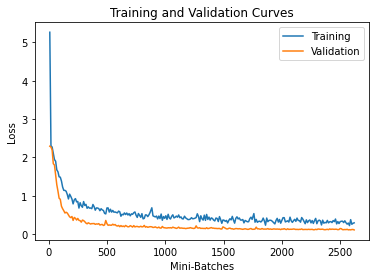

Finished Training


In [ ]:
torch_wrapper.train(epochs=3, log_mini_batches=100,
                    models_dir='/content/gdrive/My Drive/PyTorch/MNIST/model_checkpoints')

# Load Model

Loaded epoch3_model.pt in eval mode.



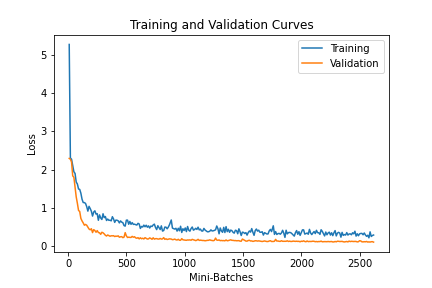

Data is split:
Training shape: ((55999, 28, 28), (55999, 10))
Validation shape: ((7000, 28, 28), (7000, 10))
Testing shape: ((7001, 28, 28), (7001, 10))

Data is loaded into DataLoaders.


In [6]:
torch_wrapper = TorchWrapper(X, y, 
                             MNISTDataset,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(64,-1,-1), num_workers=(0,0,0),
                             preprocess_data=False)

torch_wrapper.load_checkpoint(Net(),
                              checkpoints_path='/content/gdrive/My Drive/PyTorch/MNIST/model_checkpoints/20201025T232359_models/',
                              model_name='epoch3_model.pt', load_type='eval')

# Evaluate

  0%|          | 0/875 [00:00<?, ?it/s]/content/torch_wrapper.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = self.net(torch.tensor(inputs).float().to(self.device)).cpu().detach()
  1%|          | 9/875 [00:00<00:09, 88.74it/s]

Evaluating Train set...


  0%|          | 0/1 [00:00<?, ?it/s]


Average Train Accuracy: 96.75%
Average Train Hit@N: 0.0

Evaluating Validation set...


  0%|          | 0/1 [00:00<?, ?it/s]


Average Validation Accuracy: 96.46%
Average Validation Hit@N: 0.1

Evaluating Test set...


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Average Test Accuracy: 96.57%
Average Test Hit@N: 0.1



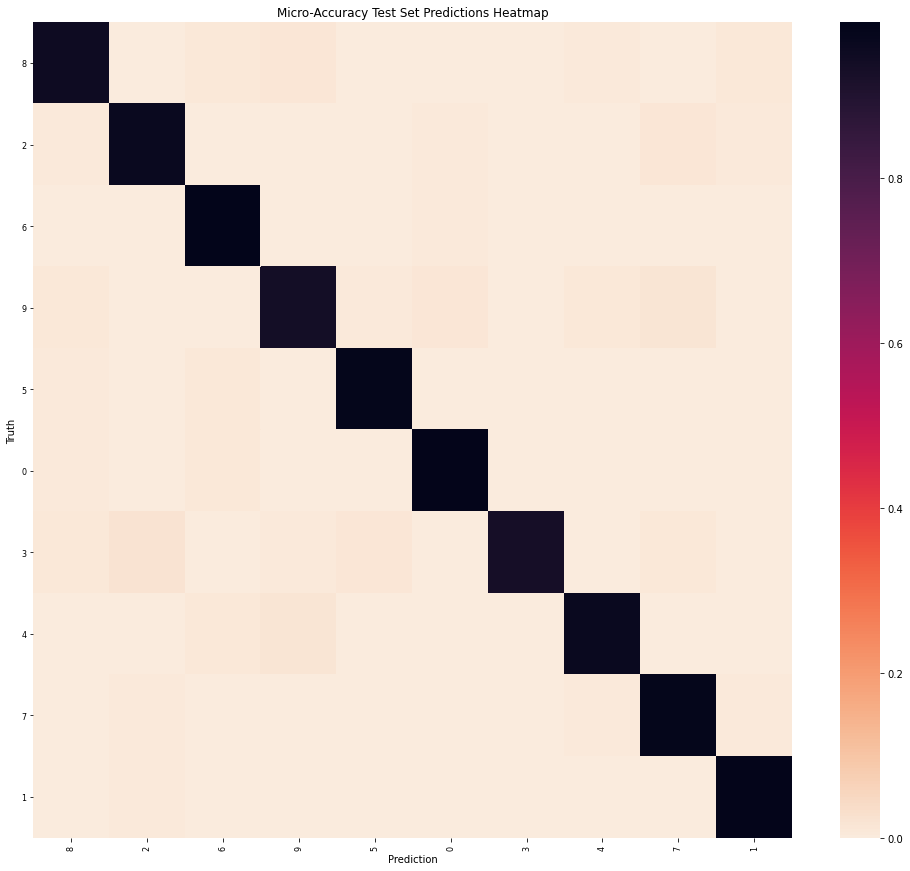

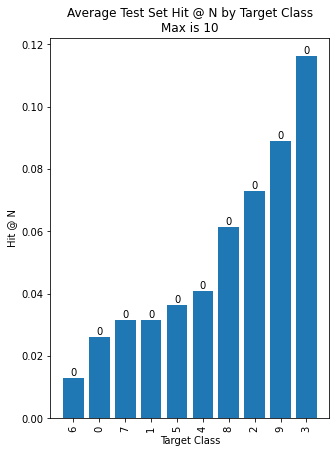

In [14]:
torch_wrapper.evaluate()